In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import metrics
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.callbacks import Callback

In [2]:
class CustomStoppingCallback(Callback):
    def __init__(self, target_loss=20, target_mae=3):
        super().__init__()
        self.target_loss = target_loss
        self.target_mae = target_mae

    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get('loss')
        mae = logs.get('mae')
        
        if loss < self.target_loss and mae < self.target_mae:
            print(f"\nEpoch {epoch+1}: Loss < {self.target_loss} and MAE < {self.target_mae}, stopping training.")
            self.model.stop_training = True

In [3]:
# Load dataset
df = pd.read_csv("dataset/air_quality_data_fix.csv")

# Fitur (input): Konsentrasi polutan
features = df[["co", "no2", "o3", "pm10", "pm25", "so2"]]
target = df["universal_aqi"]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

In [4]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Ganti Dense pertama dengan Input
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1)
])

In [5]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae', 'mse'])

custom_callback = CustomStoppingCallback(target_loss=5, target_mae=5)

In [6]:
# Latih model dengan callback
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_test, y_test), 
    callbacks=[custom_callback],
    verbose=1
)

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2648.4263 - mae: 47.4666 - mse: 2647.0237 - val_loss: 2614.7817 - val_mae: 47.2234 - val_mse: 2613.3835
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2563.6428 - mae: 46.4364 - mse: 2562.2395 - val_loss: 2265.0591 - val_mae: 43.5787 - val_mse: 2263.6284
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2156.1677 - mae: 42.2301 - mse: 2154.7170 - val_loss: 1498.7659 - val_mae: 34.5807 - val_mse: 1497.2432
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1277.6689 - mae: 31.2932 - mse: 1276.1160 - val_loss: 570.8782 - val_mae: 20.3428 - val_mse: 569.2269
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 429.4767 - mae: 17.3090 - mse: 427.7962 - val_loss: 131.8594 - val_mae: 9.6093 - val_mse: 130.1139
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 110.1723 - mae: 8.7336 - mse: 108.4181 - val_loss: 75.5156 - val_mae: 7.2167 - val_mse: 73.7500
Epoch 7/100
113/113 ━━━━━

In [7]:
# Evaluasi model pada data uji
test_loss, test_mae, test_mse = model.evaluate(X_test, y_test, verbose=1)

# Cetak hasil evaluasi
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test MSE: {test_mse}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5193 - mae: 1.1961 - mse: 2.7420
Test Loss: 4.519123077392578, Test MAE: 1.1931668519973755, Test MSE: 2.741767168045044


In [10]:
model.save('LinearModel.h5')
print("Model saved successfully in SavedModel format!")

Model saved successfully in SavedModel format!


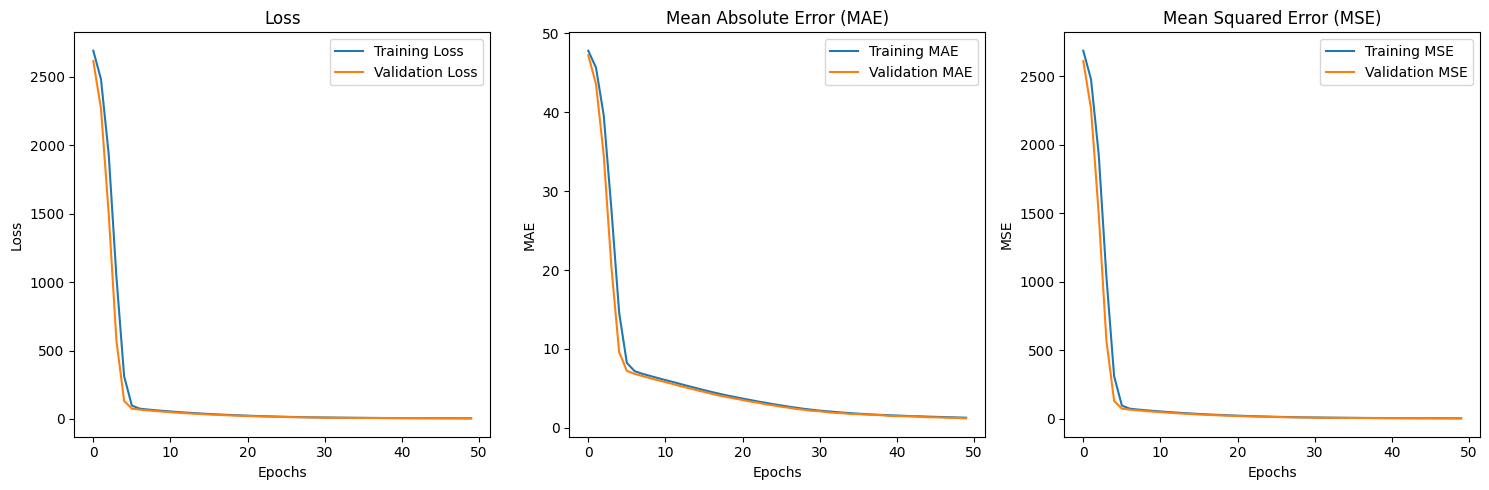

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.title('Mean Squared Error (MSE)')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
# Prediksi AQI pada data uji
y_pred = model.predict(X_test)

# Membuat DataFrame untuk membandingkan hasil prediksi dengan nilai aktual
results = pd.DataFrame({
    'Actual AQI': y_test.values,
    'Predicted AQI': y_pred.flatten()
})

# Tampilkan hasil prediksi
results.head(10)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


,Actual AQI,Predicted AQI
0,33,33.577988
1,86,85.616600
2,37,36.751652
3,23,21.841768
4,39,42.650654
5,39,40.169170
6,67,66.528343
7,31,31.287134
8,37,37.813988
9,38,40.475323


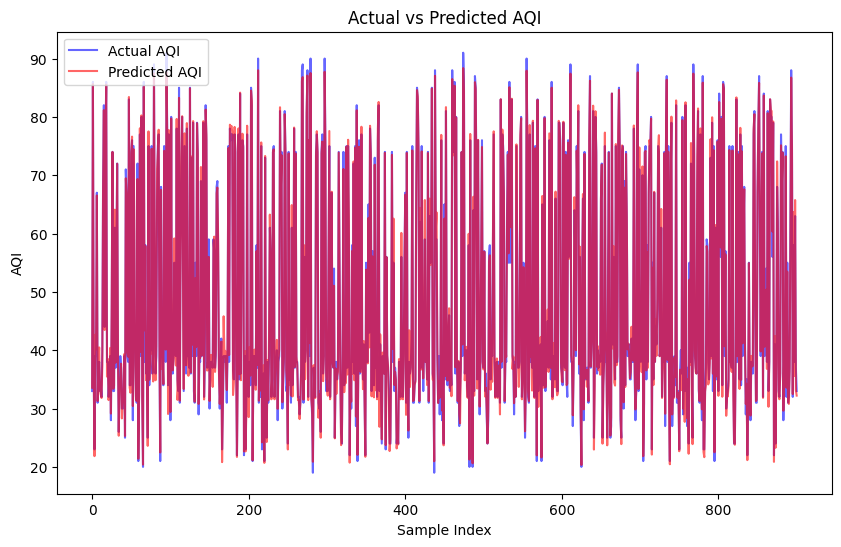

In [12]:
# Visualisasi perbandingan AQI aktual dan prediksi
plt.figure(figsize=(10, 6))
plt.plot(results['Actual AQI'], label='Actual AQI', color='blue', alpha=0.6)
plt.plot(results['Predicted AQI'], label='Predicted AQI', color='red', alpha=0.6)
plt.title('Actual vs Predicted AQI')
plt.xlabel('Sample Index')
plt.ylabel('AQI')
plt.legend()
plt.show()

In [ ]:
@register_keras_serializable()
class CustomMSE(metrics.MeanSquaredError):
    def __init__(self, name="mse", dtype=None):
        super().__init__(name=name, dtype=dtype)

model = tf.keras.models.load_model("LinearModel.h5", custom_objects={'mse': CustomMSE()})

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model yang sudah dikonversi ke format .tflite
with open('LinearModel.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model berhasil dikonversi ke format TFLite!")